# Lab 1: Linear models
## Part 1: Classification 
The [Fashion-MNIST dataset](https://www.openml.org/d/40996) contains 70,000 images of Zalando fashion products, classified into 10 types of clothing, each represented by 28 by 28 pixel values. We's see how well we can classify these with linear models. Let's start with looking at our data:

In [1]:
# General imports. Make sure you have recent versions off all required libraries installed.
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
# Library to show progress bars for iterables
from tqdm import tqdm

In [2]:
# Download FMINST data. Takes a while the first time.
fmnist = oml.datasets.get_dataset(40996)
X, y, _, _ = fmnist.get_data(target=fmnist.default_target_attribute); 
fmnist_classes = {0:"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 
                  6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

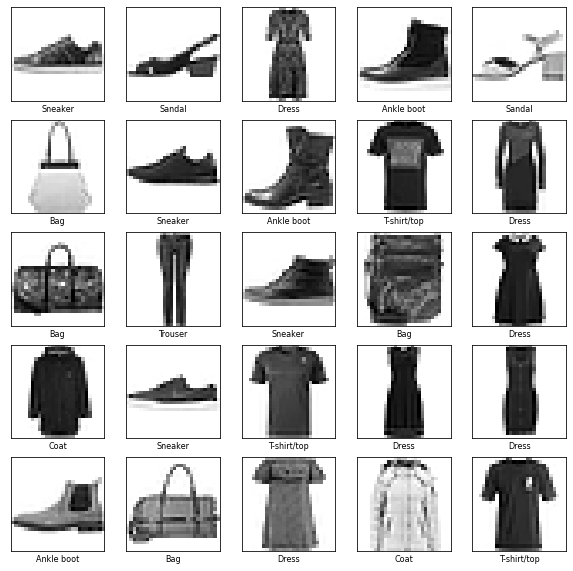

In [3]:
# Take some random examples, reshape to a 32x32 image and plot
from random import randint
fig, axes = plt.subplots(5, 5,  figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    n = randint(0,len(X.values))
    ax.imshow(X.values[n].reshape(28, 28), cmap=plt.cm.gray_r)
    ax.set_xlabel((fmnist_classes[int(y.values[n])]))
    ax.set_xticks(()), ax.set_yticks(())
plt.show();

## Exercise 1: A quick benchmark
First, we'll try the default [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) and [Linear SVMs](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html?highlight=linearsvc#sklearn.svm.LinearSVC). Click the links to read the documentation. We'll also compare it to [k-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) as a point of reference. To see whether our models are overfitting, we also evaluate the training set error. This can be done using [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) instead of  [`cross_val_scores`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score).

For now we are just interested in a quick approximation, so we don't use the full dataset for our experiments. Instead, we use 10% of our samples:

In [4]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# Take a 10% stratified subsample to speed up experimentation
Xs, _, ys, _ = train_test_split(X,y, stratify=y, train_size=0.1)

print(f"Training set contains {len(Xs)}/{len(X)} ({len(Xs) / len(X) * 100:.1f} %) items")

Training set contains 700/70000 (1.0 %) items


With this small sample of our data we can now train and evaluate the three classifiers.

### Exercise 1.1
Implement a function below which evaluates each classifier passed into it on the given data, and then returns both the train and test scores of each as a list. You are allowed to import additional functions from whichever module you like, but you should be able to complete the function with [`cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) function and standard Python built-ins. Below the function you will find example output.

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width="400" />

In [5]:
def evaluate_learners(classifiers, X, y):
    """ Evaluate each classifier in 'classifiers' with cross-validation on the provided (X, y) data. 
    
    Given a list of scikit-learn classifiers [Classifier1, Classifier2, ..., ClassifierN] return two lists:
     - a list with the scores obtained on the training samples for each classifier,
     - a list with the test scores obtained on the test samples for each classifier.
     The order of scores should match the order in which the classifiers were originally provided. E.g.:     
     [Classifier1 train score, ..., ClassifierN train score], [Classifier1 test score, ..., ClassifierN test score]
    """
    
    train_scores, test_scores = [], []
    
    for model in classifiers:
        model.fit(Xs, ys)
        results = cross_validate(model, X, y, return_train_score=True, n_jobs=-1)
        train_scores.append(results["train_score"])
        test_scores.append(results["test_score"])
    
    return train_scores, test_scores

### Exercise 1.2
Call the function you created with a Logistic Regression, Linear SVM, and k-Nearest Neighbors Classifier.
Store the return values in the variables `train_scores` and `test_scores`. Then, run the code given below to produce a plot visualizing the scores.

In [6]:
# Runnning the evaluation function on 3 classifiers
classifiers = [LogisticRegression(), LinearSVC(),  KNeighborsClassifier()]
train_scores, test_scores = evaluate_learners(classifiers, Xs, ys)

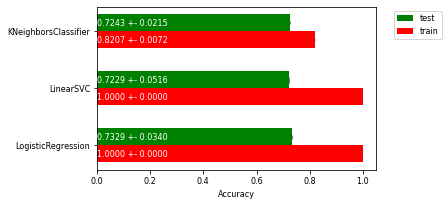

In [7]:
# Plot a bar chart of the train and test scores of all the classifiers, including the variance as error bars
fig, ax = plt.subplots()
width=0.3
ax.barh(np.arange(len(train_scores)), np.mean(test_scores, axis=1), width,
        yerr= np.std(test_scores, axis=1), color='green', label='test')
ax.barh(np.arange(len(train_scores))-width, np.mean(train_scores, axis=1), width,
        yerr= np.std(train_scores, axis=1), color='red', label='train')
for i, te, tr in zip(np.arange(len(train_scores)),test_scores,train_scores):
    ax.text(0, i, "{:.4f} +- {:.4f}".format(np.mean(te),np.std(te)), color='white', va='center')
    ax.text(0, i-width, "{:.4f} +- {:.4f}".format(np.mean(tr),np.std(tr)), color='white', va='center')
ax.set(yticks=np.arange(len(train_scores))-width/2, yticklabels=[c.__class__.__name__ for c in classifiers])
ax.set_xlabel('Accuracy')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

### Exercise 1.3
Interpret the plot. Which is the best classifier? Are any of the models overfitting? If so, what can we do to solve this? Is there a lot of variance in the results?

- KNeighborsClassifier
  - Least difference between train/test scores => Least overfitting
  - Based on overfitting and overall score possibly best classifier
- LinearSVC
  - Shows the most overfitting behavior
- LogisticRegression
  - Shows medium overfitting


The variance is low for all scores

## Exercise 2: Regularization
We will now tune these algorithm's main regularization hyperparameter: the misclassification cost in SVMs (C), the regularization parameter in logistic regression (C), and the number of neighbors (n_neighbors) in kNN. We expect the optimum for the C parameters to lie in $[10^{-12},10^{12}]$ and for n_neighbors between 1 and 50. C should be varied on a log scale (i.e. [0.01, 0.1, 1, 10, 100]) and k should be varied uniformly (i.e. [1,2,3,4]).

### Exercise 2.1
Vary the regularization parameters in the range given above and, for each classifier, create a line plot that plots both the training and test score for every value of the regularization hyperparameter. Hence, you should produce 3 plots, one for each classifier. Use the default 5-fold cross validation for all scores, but only plot the means.

Hints:
* Think about the time complexity of these models. Trying too many hyperparameter values may take too much time.
* You can make use of numpy's [logspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.logspace.html), [geomspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.geomspace.html?highlight=geomspace#numpy.geomspace), and [linspace](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html#numpy.linspace) functions.
* You can use matplotlib's default [plot](https://matplotlib.org/tutorials/introductory/pyplot.html) function to plot the train and test scores.
* You can manually loop over the hyperparameter ranges, or you can already check out scikit-learn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function to save some programming. We'll see it again later in the course.



In [8]:
# Amount of hyperparameters tested for each model
stepsize = 10

# Generate the paramater spaces according to exercise description
parameters_C = np.logspace(start=-12, stop=12, num=stepsize)
parameters_k = np.linspace(start=1, stop=50, num=stepsize, dtype="int")

print(f"Parameters to try out: ({stepsize} in total)")
for C, k in zip(parameters_C, parameters_k):
    print(f"C = {C:.3e}\tk = {k}")

Parameters to try out: (10 in total)
C = 1.000e-12	k = 1
C = 4.642e-10	k = 6
C = 2.154e-07	k = 11
C = 1.000e-04	k = 17
C = 4.642e-02	k = 22
C = 2.154e+01	k = 28
C = 1.000e+04	k = 33
C = 4.642e+06	k = 39
C = 2.154e+09	k = 44
C = 1.000e+12	k = 50


In [9]:
# Save the scores per classifier as list of: (mean_train_score, mean_test_score)
log_scores, lin_scores, knn_scores = [], [], []

for C, k in tqdm(zip(parameters_C, parameters_k), total=stepsize):
    # Setup the classifiers with variable hypterparameters and run evaluator
    classifiers = [LogisticRegression(C=C), LinearSVC(C=C), KNeighborsClassifier(n_neighbors=k)]
    train_scores, test_scores = evaluate_learners(classifiers, Xs, ys)

    # Extract the mean scores per classifier by computing mean of matrix-row
    # output is of form: [mean_classifier1, mean_classifier2, mean_classifier3]
    train_means = np.mean(train_scores, axis=1)
    test_means = np.mean(test_scores, axis=1)
    
    log_scores.append((train_means[0], test_means[0]))
    lin_scores.append((train_means[1], test_means[1]))
    knn_scores.append((train_means[2], test_means[2]))

100%|██████████| 10/10 [00:24<00:00,  2.48s/it]


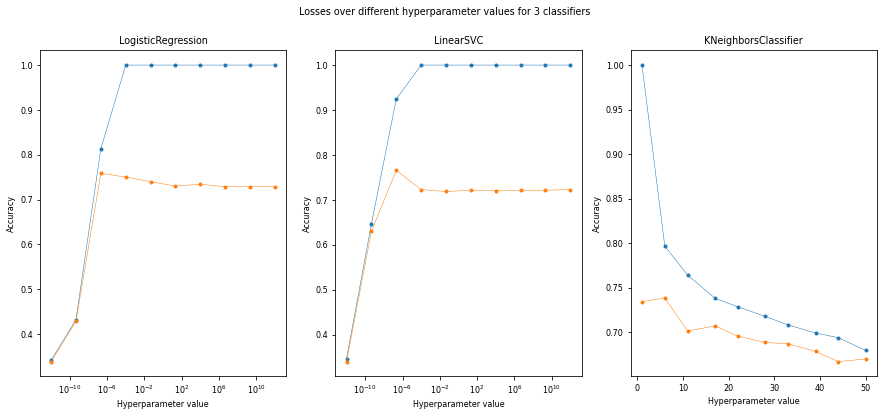

BLUE: train
ORANGE: test


In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

for ax in axes:
    ax.set(xlabel="Hyperparameter value", ylabel='Accuracy')

axes[0].set_title('LogisticRegression')
axes[0].plot(parameters_C, log_scores, marker = '.')
axes[0].set_xscale("log")

axes[1].set_title('LinearSVC')
axes[1].plot(parameters_C, lin_scores, marker = '.')
axes[1].set_xscale("log")

axes[2].set_title('KNeighborsClassifier')
axes[2].plot(parameters_k, knn_scores, marker = '.')

fig.suptitle('Losses over different hyperparameter values for 3 classifiers');
plt.show()

print("BLUE: train\nORANGE: test")

# Code to print the actual values, format: list( (parameter, (train, test)) )
# print(list(zip(parameters_k, knn_scores)))

### Exercise 2.2
Interpret the plots. When are the methods underfitting? When are they overfitting? How sensitive are they to the regularization hyperparameter?

* _LogisticRegression_: The test score is at its highest for $C=2.15e-7$. When we increase the parameter further the model shows overfitting since the train score increases while the test score remains the same.
* _LinearSVC_: The test score is also at its highest for $C=2.15e-7$. Now when we further increase the parameter we do not only see overfitting but also a drop in test score
* The score of _kNN_ drops when increasing the amount of neighbours the algorithm takes into account. The model starts of with strong overfitting behavoir and converges to a score of around 0.80 where the train and test score match. From the plot we see that $k=6$ is the best parameter because any lower would lead to almost no gain in test score while increasing the overfitting We can also conclude that kNN is very sensitive to its hyperparameter

#### Values
* LogisticRegregression: (2.1544346900318822e-07, (0.84, 0.82))
* LinearSVC: (2.1544346900318822e-07, (0.88, 0.83))
* kNN: (6, (..., ...))

## Exercise 3: Interpreting misclassifications
Chances are that your models are not yet perfect. It is important to understand what kind of errors it still makes. Let's take a closer look at which instances are misclassified and which classes are often confused.
Train the logistic regression model with `C=1e-7`. Train the model on a training set, and make predictions for a test set (both sets should be  sampled from our 10% subsample).

In [11]:
# Create a stratified train-test split on a sample
X_train, X_test, y_train, y_test = train_test_split(Xs,ys, stratify=ys, random_state=0)

### Exercise 3.1
Train the classifier as described above, obtain the predictions `y_pred` on the test set, and identify all the misclassified samples `misclassified_samples`. Then, run the visualization code below to study the misclassifications

In [12]:
# Fit model and generate prediction on test set
model = LogisticRegression(C=1e-7)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Compute the score by comparing prediction to test results
print(f"score {(y_pred == y_test).mean():.3f}")

# List all ids of observations that do not equal to their spot in the y_test set
misclassified_samples = [
    i for i, y_hat, y in zip(range(len(y_pred)), y_pred, y_test) if y is not y_hat
]

print("misclassified_samples", len(misclassified_samples))
print("y_pred", len(y_pred))

score 0.726
misclassified_samples 48
y_pred 175


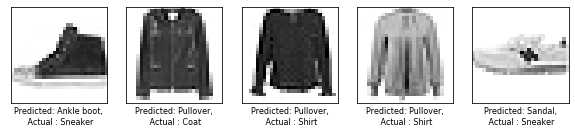

In [13]:
# Visualize the (first five) misclassifications, together with the predicted and actual class
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for nr, i in enumerate(misclassified_samples[:5]):
    axes[nr].imshow(X_test.values[i].reshape(28, 28), cmap=plt.cm.gray_r)
    axes[nr].set_xlabel("Predicted: %s,\n Actual : %s" % (fmnist_classes[int(y_pred[i])],fmnist_classes[int(y_test.values[i])]))
    axes[nr].set_xticks(()), axes[nr].set_yticks(())

plt.show();

### Exercise 3.2
Interpret the results. Are these misclassifications to be expected?

The predictions are domain-wise not 'far' off the actual values.

### Exercise 3.3.
Run the code below on your results to draw the complete confusion matrix and get more insight on the systematic misclassifications 
of your model. A confusion matrix shows the amount of examples in for each pair of true and predicted classes. Interpret the results. 
Does your model produce certain types of error more often than other types? 

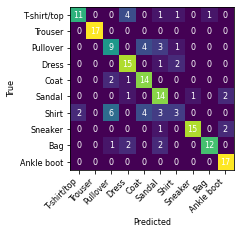

In [14]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm)
ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
ax.set_xticklabels(list(fmnist_classes.values()), rotation=45, ha="right")
ax.set_yticklabels(list(fmnist_classes.values()))
ax.set_ylabel('True')
ax.set_xlabel('Predicted')
for i in range(100):
    ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")

Some classes are almost always correctly classified (like bags and trousers) while for example pullovers are often confused with coats. And sneakers with sandals.

## Exercise 4: Interpreting model parameters
Finally, we'll take a closer look at the model parameters, i.e. the coefficients of our linear models. Since we are dealing with 28x28 pixel images, we have to learn 784 coefficients. What do these coefficients mean? We'll start by plotting them as 28x28 pixel images.

### Exercise 4.1
Train a Logistic Regression model and a Linear SVM using their tuned hyperparameters from exercise 2. 
When in doubt, use `C=1e-7` for LogReg and `C=1e-8` for the SVM. 
Pass the trained model to the provided plotting function. Interpret the results in detail.

In [15]:
def plot_coefficients(model, name=None):
    """
    Plots the coefficients of the given model as 28x28 heatmaps.
    The `name` attribute is optional, it is simply a title for the produced figure
    """
    fig, axes = plt.subplots(1,10,figsize=(20,2))
    fig.suptitle(name if name else model.__class__.__name__)
    for i, ax in enumerate(axes):
        m = ax.imshow(model.coef_[i].reshape(28,28))
        ax.set_xlabel(fmnist_classes[i])
        ax.set_xticks(()), ax.set_yticks(())
    fig.colorbar(m, ax=axes.ravel().tolist())

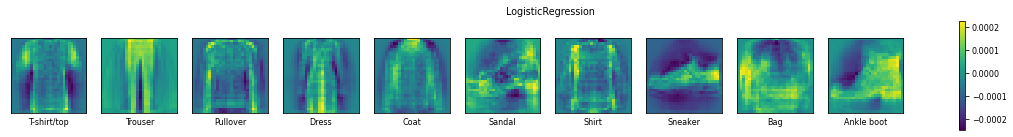

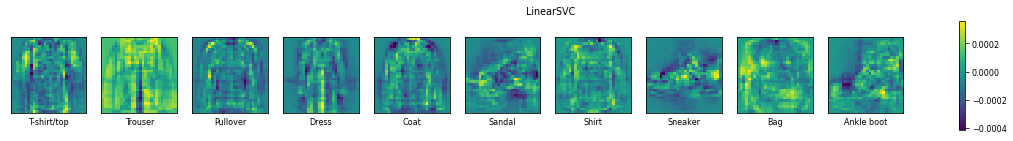

In [16]:
C_optimal_log = 2.1544346900318822e-07
C_optimal_lin = 2.1544346900318822e-07

# Hyperparameters from the exercise text
# C_optimal_log = 1e-7
# C_optimal_lin = 1e-8

model_lr = LogisticRegression(C=C_optimal_log)
model_svc = LinearSVC(C=C_optimal_lin)

model_lr.fit(X_train, y_train)
model_svc.fit(X_train, y_train)

plot_coefficients(model_lr)
plot_coefficients(model_svc)

* Why do you get multiple plots per model?

This is because Linear SVM and Logistic Regression use a one-vs-rest and one-vs-one approach to tackle multi-class classification. Since the nature of both models is to efficiently classifiy binary classes the model will first classify one agains all the other models, and does this until all classes are checked. Therefore we need multiple sets of coefficients to seperate all classes individually.

* What do the features represent in your data.

All the 784 features are refering to pixel data starting from (0,0) in the image to ()

* Does it seems like the models pay attention to the right features?

For example for Dress and Trousers, both models look for the right pixels. Trousers should have 'empty space' between the two trouser legs and the image shows that there is a negative coefficient at that place. Also both models show a positive coefficient centered vertical line for the dress indicating that a dress is a vertical object with no 'empty space' in the middel.

* Do you models seem to ignore certain features?

It seems to forget that a coat can also have a negative vertical line like trousers since the coat can be opened in the picture (like the misclassified image examples)

* Do you observe differences in quality between the different classes?

We can see by eye that the image of a bag is not clearly codified at coefficient by both models when comparing it to images of bags that are in the dataset

* Do you observe any differences between the models?

There is a clear difference in the overal interpretation of the classes between the models. It can be seen that the LinearSVC model looks more _noisy_ while the LogisticRegression model has a more _smooth_ coefficient space. This is explained by the underlying nature of the models.

### Exercise 4.2
Repeat the previous exercise, but now only with logistic regression. In addition to a tuned version, also add a model that overfits a lot and one that underfits a lot. Interpret and explain the results.

_Overfit_: look in plot where train is (clearly) higher than test score (right part of plot)

_Underfit_: where scores are generally low (left part of plot)

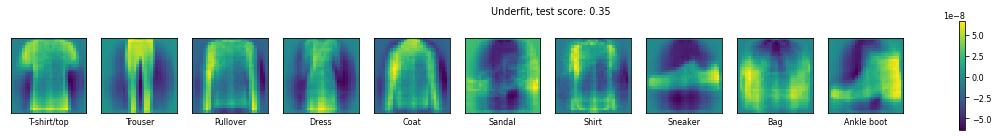

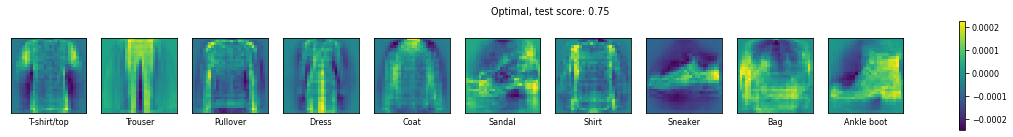

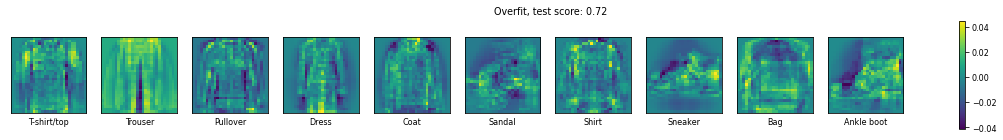

In [17]:
def score(model):
    """Run a model on the test set (X_test, y_test) and return it's score as a single float"""
    return (y_test == model.predict(X_test)).mean()

# Numbers extracted from the accuracy plots
C_underfit = 10e-12
C_optimal = 2.1544346900318822e-07
C_overfit = 10e4

# Fit the (not-)tuned models on the training data
model_lr_underfit = LogisticRegression(C=C_underfit).fit(X_train, y_train)
model_lr_optimal = LogisticRegression(C=C_optimal).fit(X_train, y_train)
model_lr_overfit = LogisticRegression(C=C_overfit).fit(X_train, y_train)

# Plot the coefficients and show the test score too
plot_coefficients(model_lr_underfit, name=f"Underfit, test score: {score(model_lr_underfit):.2f}")
plot_coefficients(model_lr_optimal, name=f"Optimal, test score: {score(model_lr_optimal):.2f}")
plot_coefficients(model_lr_overfit, name=f"Overfit, test score: {score(model_lr_overfit):.2f}")

* _Underfit_ shows very vage and general patterns with high coeffiecent values. The images are clearly visisble but are bad for classification in general
* _Optimal_ shows high coeffiecent values where classes differ
* _Overfit_ shows a lot of noise. This is trained to classify the training set correctly
